In [43]:
import numpy as np
import pylab as plt
from scipy.linalg import inv
from scipy import stats

## Task

Goal is to solve a simple linear regression task, for a model with three coefficients
$$y(x) = \frac15 v_0 + v_1\cdot x + v_2 \cdot x^2$$

Assume we have measurements 
$$
d_i \sim  \mathcal{N}(y(x_i), \sigma = 0.05)
$$
at the points:
$$ x_i = 0,\; 0.1,\; 0.2, \;\dots,\; 1.0$$

In [44]:
# Model and true parameters
N = 11
x = np.linspace(0, 1, N)
T = np.array([0*x+0.2, x, x**2]).T
v_true = np.array([-0.2, 0., 0.2])

In [45]:
# Data
SIGMA = 0.05
np.random.seed(42)
DATA = T.dot(v_true) + np.random.randn(N)*SIGMA

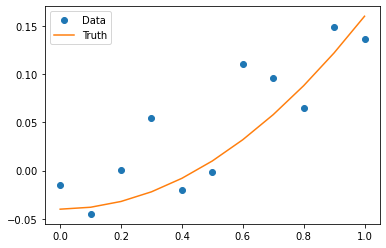

In [46]:
plt.plot(x, DATA, marker='o', ls='', label="Data")
plt.plot(x, T.dot(v_true), label='Truth')
plt.legend()

## Reference analysis

In [47]:
# Linear regression (Murphy)
v_lr = inv(T.T.dot(T)).dot(T.T.dot(DATA))
y_lr = T.dot(v_lr)

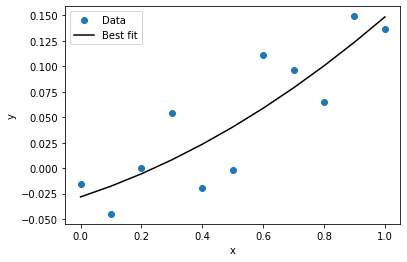

In [48]:
# Data vs linear regression best fit
plt.plot(x, DATA, ls='', marker='o', label = 'Data')
plt.plot(x, y_lr, 'k', label = 'Best fit')
plt.legend()
plt.xlabel("x")
plt.ylabel('y');

In [49]:
# Fisher estimation of errors
I = np.array([[(T[:,i]*T[:,j]).sum()/SIGMA**2 for i in range(3)] for j in range(3)])
Sigma = inv(I)
v_fisher_err = np.diag(Sigma)**0.5

for i in range(3):
    print("v_%i = %.3f +- %.3f"%(i, v_lr[i], v_fisher_err[i]))

v_0 = -0.141 +- 0.190
v_1 = 0.098 +- 0.177
v_2 = 0.079 +- 0.171


## SWYFT!

In [50]:
import swyft

In [51]:
def model(v):
    y = T.dot(v)
    return dict(y=y)

sim = swyft.Simulator(model, ['v0', 'v1', 'v2'], dict(y=(11,)))

In [52]:
store = swyft.MemoryStore(sim)

Creating new store.


In [53]:
prior = swyft.Prior(lambda u: u*2 - 1, 3)  # Unif(-1, 1)

In [86]:
store.add(20000, prior)

Store: Adding 17176 new samples to simulator store.


In [87]:
store.simulate()

In [88]:
def noise(sim, v):
    return dict(d = sim['y'] + np.random.randn(11)*SIGMA)

In [89]:
dataset = swyft.Dataset(20000, prior, store, simhook = noise)

In [90]:
post = swyft.Posteriors(dataset)

In [91]:
%%time
marg = [0, 1, 2]
post.add(marg, device = 'cuda')
post.train(marg, max_epochs = 100)

Training: lr=0.001, Epoch=11, VL=2.296
CPU times: user 26.8 s, sys: 3.27 s, total: 30.1 s
Wall time: 40.8 s


In [92]:
obs = dict(d= DATA)
samples = post.sample(1000000, obs)

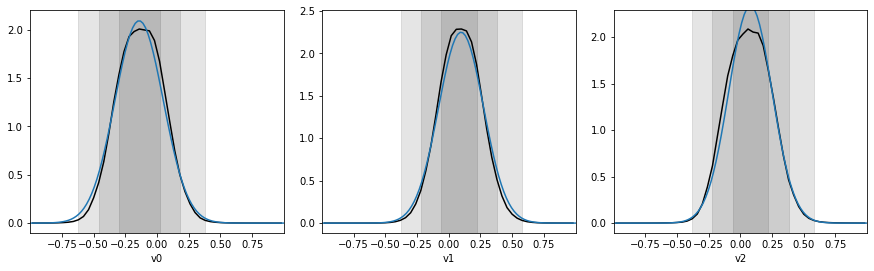

In [93]:
fig, diag = swyft.plot_1d(samples, [0, 1, 2], bins = 50, figsize=(15,4))
for i in range(3):
    x = np.linspace(-1, 1, 100)
    fig.axes[i].plot(x, stats.norm.pdf(x, v_lr[i], v_fisher_err[i]))

[[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]]


(<Figure size 720x720 with 9 Axes>,
 {(0,): {'mean': -0.13030888869375123,
   'mode': -0.1499998183016416,
   'HDI1': (-0.30999958423469887, 0.02999991837304783),
   'HDI2': (-0.4699993501677561, 0.18999968430610503),
   'HDI3': (-0.6299991161008134, 0.3899993917224266),
   'entropy': -0.3033329931988552},
  (0, 1): None,
  (1,): {'mean': 0.09239421550314797,
   'mode': 0.1299996263912392,
   'HDI1': (-0.05000020669452582, 0.24999951511508256),
   'HDI2': (-0.21000005832631702, 0.40999936674687376),
   'HDI3': (-0.389999891412082, 0.5899991998326387),
   'entropy': -0.3913844592602352},
  (0, 2): None,
  (1, 2): None,
  (2,): {'mean': 0.06983128486392276,
   'mode': 0.050000556741020996,
   'HDI1': (-0.08999933660577353, 0.23000041961547102),
   'HDI2': (-0.2499992147163958, 0.39000029772609324),
   'HDI3': (-0.4099990928270181, 0.5900001453643711),
   'entropy': -0.3325418565893271}})

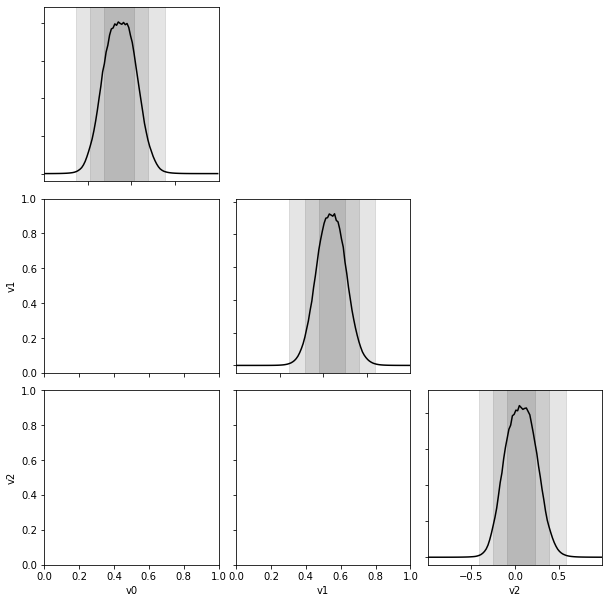

In [96]:
swyft.plot_corner(samples, [0, 1, 2])

In [97]:
%%time
marg = [(0, 1), (0, 2)]
post.add(marg, device = 'cuda')
post.train(marg, max_epochs = 100)

Training: lr=0.0001, Epoch=22, VL=0.6606
CPU times: user 52.6 s, sys: 6.48 s, total: 59 s
Wall time: 1min 20s


In [98]:
samples = post.sample(1000000, obs)

[[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]]


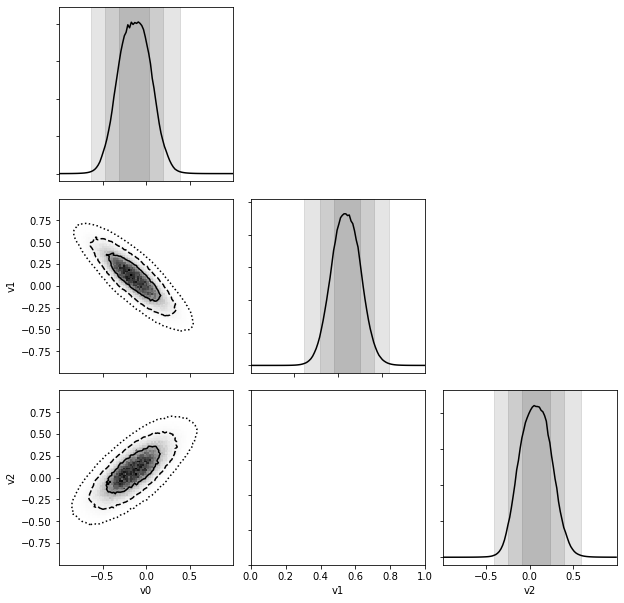

In [99]:
swyft.plot_corner(samples, [0, 1, 2]);